In [1]:
import pandas as pd
import urllib

import numpy as np

import json

from tqdm.autonotebook import tqdm

#%matplotlib inline

tqdm.pandas()

import dask.dataframe as dd

from dask.multiprocessing import get
from dask.diagnostics import ProgressBar

from datetime import datetime
import matplotlib.pyplot as plt

from IPython.display import display


/tmp/ipykernel_386608/3514129619.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import urllib3

In [3]:
http = urllib3.PoolManager()

# Functions

In [4]:
ws_hostname = "127.0.1.1"
ws_hostname = "172.27.0.64"


street_field  = "streetName"
housenbr_field = "houseNumber"
postcode_field = "postCode"
city_field  =    "city"
country_field =  "country"
addr_key_field = "addrKey"

# ws_hostname = "192.168.1.3"

In [5]:

sample_size = None# 1000
def get_addresses(addresses_filename):
    addresses = pd.read_csv(addresses_filename,  
                            usecols = lambda x: x in [addr_key_field, "addr_key",
                                       country_field, 
                                       postcode_field, 
                                       city_field, 
                                       street_field, 
                                       housenbr_field,
                                       country_field], 
                           dtype={postcode_field: str, housenbr_field: str, country_field: str})
    
    
    addresses = addresses.rename(columns={"addr_key": addr_key_field})
    if country_field in addresses: 
        addresses[country_field] =addresses[country_field].fillna("Belgique")
    else: 
        addresses[country_field] = "Belgique"
    #addresses = addresses.rename(columns={"index":addr_key_field})
    
    addresses = addresses[addresses[street_field].notnull() & addresses[city_field].notnull()] # & addresses[country_field].isnull() ]
    
    addresses[postcode_field] = addresses[postcode_field].astype(str)
    
    if sample_size: 
        addresses = addresses.sample(sample_size, random_state=0)
    
    return addresses#.drop(country_field, axis=1)

In [6]:
def call_ws(addr_data, check_result=True, structured_osm=False, with_rejected=False, mode="long"): #lg = "en,fr,nl"
    t = datetime.now()
    
    try: 
        r = http.request(
        'GET',
        f'http://{ws_hostname}:5000//REST/nominatimWrapper/v0.1/geocode',
        fields= { 
             street_field: addr_data[street_field],
             housenbr_field: addr_data[housenbr_field],
             city_field: addr_data[city_field],
             postcode_field: addr_data[postcode_field],
             country_field: addr_data[country_field],
             addr_key_field: addr_data[addr_key_field] if addr_key_field in addr_data else None  ,
             "checkResult" : check_result,
             "structOsm" : structured_osm,
            "withRejected": with_rejected,
            "mode": mode

        })
        

    except Exception as e:
        print("Exception !")
        print(addr_data)
        print(e)
        raise e
        
    if r.status == 204:
        print("No result!")
        print(addr_data)
        print(r.data)
        return
    elif r.status == 200:
        try:
            res = json.loads(r.data.decode('utf-8'))
            res["time"] = (datetime.now() - t).total_seconds()
        except ValueError as ve:

            print("Cannot decode result:")
            print(ve)
            print(r.data.decode('utf-8'))
            return r.data
        return res
    else: 
        print(f"Unknown return code: {r.status} ")
        print(r.data)



In [7]:
def split_columns(addresses_batch):
    output = pd.DataFrame(index=addresses_batch.index, dtype=str)

    for f in addresses_batch:
#        print(f)
        grp= addresses_batch[f].apply(lambda r : pd.Series(r, dtype=str) if pd.notnull(r) else pd.Series(dtype=str)) 
        grp = pd.concat({f: grp}, names=['L0', 'L1'], axis=1)
        
        output = pd.concat([output, grp], axis=1)
    # display(output)
    output.columns = pd.MultiIndex.from_tuples(output.columns)
    return output  

In [8]:
def format_ws_res(addresses):
    # assert addresses.json.apply(lambda js: "match" in js).all()
    assert addresses.json.apply(lambda js: len(js["match"])==1 if js is not None and "match" in js else True).all()
    addresses_out = addresses.json.apply(lambda js: pd.Series(js["match"][0]) if js is not None and "match" in js else pd.Series(dtype=object))
    
    addresses_out =  split_columns(addresses_out)
    return addresses_out

In [9]:
def call_ws_batch(addr_data, mode="geo", with_rejected=False, check_result=True, structured_osm=False): #lg = "en,fr,nl"
    file_data = addr_data.to_csv(index=False)
    
    r = http.request(
    'POST',
    f'http://{ws_hostname}:5000/REST/nominatimWrapper/v0.1/batchGeocode',
    fields= { 
        'media': ('addresses.csv', file_data),
        'mode': mode,
        "withRejected": with_rejected,
        "checkResult" : check_result,
        "structOsm"   : structured_osm,
        #"extra_house_nbr": "no"
    })
    
    try:
        
        res_json = json.loads(r.data.decode('utf-8'))
        if "match" in res_json:
            match =  split_columns(pd.DataFrame(res_json["match"]))
            rejected= split_columns(pd.DataFrame(res_json["rejected"])) if "rejected" in res_json and len(res_json["rejected"])>0 else pd.DataFrame()
            
        else :
            match =  split_columns(pd.DataFrame(res_json))
            rejected=None
    except ValueError as ve:
        
        print("Cannot decode result:")
        print(ve)
        print(r.data.decode('utf-8'))
     
        return r.data
    
    if rejected is not None:
        return match, rejected
    
    else :
        return match
    


In [10]:
# def expand_batch_address(addresses):
#     for field in [street_field, housenbr_field, postcode_field, city_field]:
#         addresses["addrOut"+field]= addresses.address.apply(lambda d: d[field] if d is not None and field in d else "")
#     return 

# Calls

## Single address calls

In [11]:
res=call_ws({
    addr_key_field: 5,
    street_field:   "Avenue Fonsny", \
         housenbr_field: "20",\
         city_field:     "Saint-Gilles",\
         postcode_field: "1060",\
         country_field:  "Belgique"}, check_result=False, structured_osm=True, with_rejected=False, mode="long")
res

{'match': [{'work': {'method': 'fast',
    'transformedAddress': 'Avenue Fonsny, 20, 1060 Saint-Gilles, Belgique'},
   'nominatim': {'displayName': '20, Avenue Fonsny - Fonsnylaan, Saint-Gilles - Sint-Gillis, Brussel-Hoofdstad - Bruxelles-Capitale, Région de Bruxelles-Capitale - Brussels Hoofdstedelijk Gewest, 1060, België / Belgique / Belgien',
    'placeId': 182128,
    'lat': '50.8358677',
    'lon': '4.3385087',
    'placeRank': 30,
    'houseNumber': '20',
    'road': 'Avenue Fonsny - Fonsnylaan',
    'town': 'Saint-Gilles - Sint-Gillis',
    'county': 'Brussel-Hoofdstad - Bruxelles-Capitale',
    'region': 'Région de Bruxelles-Capitale - Brussels Hoofdstedelijk Gewest',
    'postcode': '1060',
    'country': 'België / Belgique / Belgien',
    'countryCode': 'be'},
   'output': {'streetName': 'Avenue Fonsny - Fonsnylaan',
    'city': 'Saint-Gilles - Sint-Gillis',
    'houseNumber': '20',
    'country': 'België / Belgique / Belgien',
    'postCode': '1060',
    'inHouseNumber': '20

In [12]:
res.keys()

dict_keys(['match', 'time'])

In [13]:
res=call_ws({street_field:   "Avenue Fonsny", \
         housenbr_field: "20",\
         city_field:     "Saint-Gilles",\
         postcode_field: "1060",\
         country_field:  "Belgique"}, check_result=False, structured_osm=False, with_rejected=True)
res

{'match': [{'work': {'method': 'fast',
    'transformedAddress': 'Avenue Fonsny, 20, 1060 Saint-Gilles, Belgique'},
   'nominatim': {'displayName': '20, Avenue Fonsny - Fonsnylaan, Saint-Gilles - Sint-Gillis, Brussel-Hoofdstad - Bruxelles-Capitale, Région de Bruxelles-Capitale - Brussels Hoofdstedelijk Gewest, 1060, België / Belgique / Belgien',
    'placeId': 182128,
    'lat': '50.8358677',
    'lon': '4.3385087',
    'placeRank': 30,
    'houseNumber': '20',
    'road': 'Avenue Fonsny - Fonsnylaan',
    'town': 'Saint-Gilles - Sint-Gillis',
    'county': 'Brussel-Hoofdstad - Bruxelles-Capitale',
    'region': 'Région de Bruxelles-Capitale - Brussels Hoofdstedelijk Gewest',
    'postcode': '1060',
    'country': 'België / Belgique / Belgien',
    'countryCode': 'be'},
   'output': {'streetName': 'Avenue Fonsny - Fonsnylaan',
    'city': 'Saint-Gilles - Sint-Gillis',
    'houseNumber': '20',
    'country': 'België / Belgique / Belgien',
    'postCode': '1060',
    'inHouseNumber': '20

## Batch calls (row by row)

In [65]:
addresses = pd.concat([
   get_addresses("data/address_restobe.csv.gz").assign(dataset="resto"),
   get_addresses("data/address_best.csv.gz").assign(dataset="best"),
   get_addresses("data/address_cbe.csv.gz").assign(dataset="cbe")
])
addresses = addresses.reset_index(drop=True)
addresses[addr_key_field] = addresses.index.astype(str)
addresses

,addrKey,streetName,houseNumber,city,postCode,country,dataset
0,0,Chaussée de Namur,198,LEUZE,5310,Belgique,resto
1,1,Rue de la Halle,11,NAMUR,5000,Belgique,resto
2,2,Avenue Jacques Sermon,38,GANSHOREN,1083,Belgique,resto
3,3,rue du Centre,200,WAIMES,4950,Belgique,resto
4,4,Kleine Waterstraat,9,HULSHOUT,2235,Belgique,resto
...,...,...,...,...,...,...,...
2995,2995,Rue du Wainage(VEL),62,Sambreville,5060,Belgique,cbe
2996,2996,Chaussée de Tournai(R-C),4,Tournai,7520,Belgique,cbe
2997,2997,Rue Louis Caty(B),32,Saint-Ghislain,7331,Belgique,cbe
2998,2998,Drève des Bouleaux,5,Braine-le-Comte,7090,Belgique,cbe


In [15]:
# addresses = pd.read_csv("data/address_bad.csv")
# addresses


### Simple way

In [16]:
# addresses = addresses[addresses.streetName.str.lower().str.contains("steenweg op antwerpen")]

# # addresses = addresses.loc[[100,112,118,142,155,179,198]]
# # addresses = addresses.loc[[ 94,  100,  198, ]]
# addresses = addresses.loc[0:100]
# addresses

In [17]:
addresses_seq = addresses.copy()

t = datetime.now()
addresses_seq["json"] = addresses_seq.fillna("").progress_apply(call_ws, check_result=False, structured_osm=False, with_rejected=True, 
                                                                mode="short",axis=1)
tot_time = (datetime.now() - t).total_seconds()
print(f"{tot_time:.2f} seconds, {addresses_seq.shape[0]/tot_time:.2f} it/s")
# KBO dataset:
# Normal mode: 128.78 seconds, 7.77 it/s
# Fastmode:     68.80 seconds, 14.54 it/s

#Resto dataset: 
# Normal mode: 145.73 seconds, 6.86 it/s
# Fast mode:    82.99 seconds, 12.05 it/s

# Best dataset:
# Normal mode: 108.53 seconds, 9.21 it/s
# Fast mode: 37.44 seconds, 26.71 it/s

addresses_seq

  0%|          | 0/3000 [00:00<?, ?it/s]

No result!
addrKey                      784
streetName     route de Balmoral
houseNumber                   35
city                SART-LEZ-SPA
postCode                    4845
country                 Belgique
dataset                    resto
Name: 784, dtype: object
b''
147.55 seconds, 20.33 it/s


,addrKey,streetName,houseNumber,city,postCode,country,dataset,json
0,0,Chaussée de Namur,198,LEUZE,5310,Belgique,resto,"{'match': [{'input': {'addrKey': '0'}, 'nomina..."
1,1,Rue de la Halle,11,NAMUR,5000,Belgique,resto,"{'match': [{'input': {'addrKey': '1'}, 'nomina..."
2,2,Avenue Jacques Sermon,38,GANSHOREN,1083,Belgique,resto,"{'match': [{'input': {'addrKey': '2'}, 'nomina..."
3,3,rue du Centre,200,WAIMES,4950,Belgique,resto,"{'match': [{'input': {'addrKey': '3'}, 'nomina..."
4,4,Kleine Waterstraat,9,HULSHOUT,2235,Belgique,resto,"{'match': [{'input': {'addrKey': '4'}, 'nomina..."
...,...,...,...,...,...,...,...,...
2995,2995,Rue du Wainage(VEL),62,Sambreville,5060,Belgique,cbe,"{'match': [{'input': {'addrKey': '2995'}, 'nom..."
2996,2996,Chaussée de Tournai(R-C),4,Tournai,7520,Belgique,cbe,"{'match': [{'input': {'addrKey': '2996'}, 'nom..."
2997,2997,Rue Louis Caty(B),32,Saint-Ghislain,7331,Belgique,cbe,"{'match': [{'input': {'addrKey': '2997'}, 'nom..."
2998,2998,Drève des Bouleaux,5,Braine-le-Comte,7090,Belgique,cbe,"{'match': [{'input': {'addrKey': '2998'}, 'nom..."


In [18]:
timing = addresses_seq[["dataset"]].copy()
timing["time"] =addresses_seq.json.apply(lambda j: j["time"] if j else None) 
timing["method"] =addresses_seq.json.apply(lambda j: j["match"][0]["work"]["method"] if j else None) 

timing

,dataset,time,method
0,resto,0.032752,fast
1,resto,0.023919,fast
2,resto,0.018953,fast
3,resto,0.040030,fast
4,resto,0.025666,fast
...,...,...,...
2995,cbe,0.125505,regex[init]
2996,cbe,0.061493,fast
2997,cbe,0.045450,fast
2998,cbe,0.030726,fast


<AxesSubplot:title={'center':'Avg call duration'}, xlabel='dataset'>

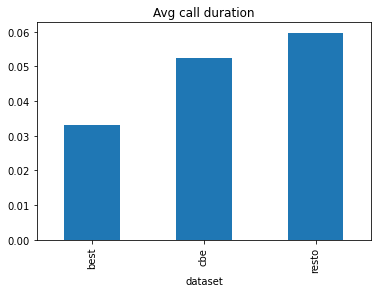

In [19]:
(timing.groupby("dataset").time.mean()).plot.bar(title="Avg call duration")

<AxesSubplot:title={'center':'Avg call duration'}, xlabel='method'>

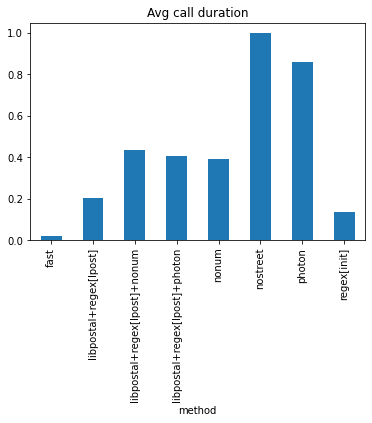

In [20]:
(timing.groupby("method").time.mean()).plot.bar(title="Avg call duration")

<AxesSubplot:xlabel='dataset'>

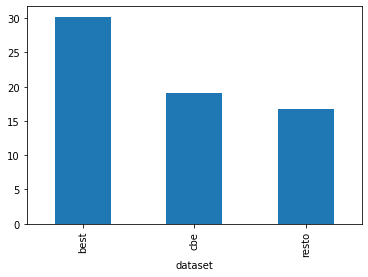

In [21]:
(1/timing.groupby("dataset").time.mean()).plot.bar("Iterations per seconds")

dataset
best     AxesSubplot(0.125,0.125;0.775x0.755)
cbe      AxesSubplot(0.125,0.125;0.775x0.755)
resto    AxesSubplot(0.125,0.125;0.775x0.755)
Name: time, dtype: object

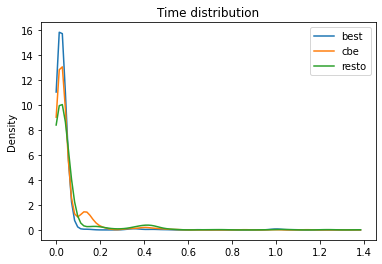

In [22]:
timing.groupby("dataset").time.plot.kde(legend=True, ind=np.linspace(0,timing.time.max(), 100 ), title="Time distribution" )

method
fast                             AxesSubplot(0.125,0.125;0.775x0.755)
libpostal+regex[lpost]           AxesSubplot(0.125,0.125;0.775x0.755)
libpostal+regex[lpost]+nonum     AxesSubplot(0.125,0.125;0.775x0.755)
libpostal+regex[lpost]+photon    AxesSubplot(0.125,0.125;0.775x0.755)
nonum                            AxesSubplot(0.125,0.125;0.775x0.755)
nostreet                         AxesSubplot(0.125,0.125;0.775x0.755)
regex[init]                      AxesSubplot(0.125,0.125;0.775x0.755)
Name: time, dtype: object

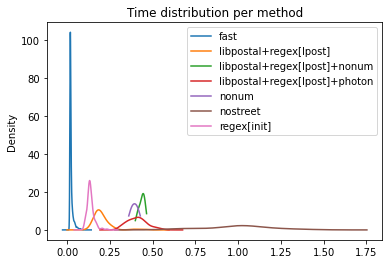

In [23]:
mthd_vc= timing.method.value_counts()
mthd_vc[mthd_vc==1]
timing[~timing.method.isin(mthd_vc[mthd_vc==1].index)][["method", "time"]].groupby("method").time.plot.kde(legend=True, title="Time distribution per method" )

<AxesSubplot:title={'center':'time'}, xlabel='[dataset]'>

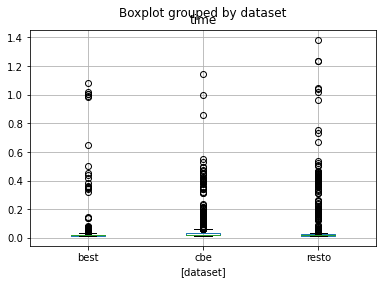

In [24]:
timing[["time", "dataset"]].boxplot(by="dataset")#.boxplot()

<AxesSubplot:title={'center':'Iterations per second'}>

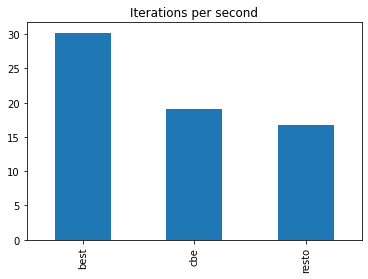

In [25]:
(timing.dataset.value_counts()/timing.groupby("dataset").time.sum()).plot.bar(title="Iterations per second")

In [26]:
addresses_seq_out = format_ws_res(addresses_seq)
addresses_seq_out

input           nominatim                                       work  \
     addrKey                 lat                 lon placeRank       method   
0          0          50.5556305   4.907401297756147        30         fast   
1          1          50.4627801           4.8655064        26         fast   
2          2  50.868676699999995   4.321060219298245        30         fast   
3          3          50.4161219           6.1119552        26         fast   
4          4          51.0399911           4.8089699        30         fast   
...      ...                 ...                 ...       ...          ...   
2995    2995           50.462361  4.5964580703527815        30  regex[init]   
2996    2996          50.6394448           3.3490581        26         fast   
2997    2997          50.4797372           3.8389755        26         fast   
2998    2998          50.6063976           4.1594953        26         fast   
2999    2999          50.4919286   5.866972229816352        30         fast   

                                          output                               \
                                      streetName             city houseNumber   
0                              Chaussée de Namur            Leuze         198   
1                                Rue de la Halle            Namur         NaN   
2     Avenue Jacques Sermon - Jacques Sermonlaan        Ganshoren          38   
3                                  Rue du Centre           Waimes         NaN   
4                             Kleine Waterstraat         Hulshout           9   
...                                          ...              ...         ...   
2995                              Rue du Wainage      Sambreville          62   
2996                         Chaussée de Tournai   Ramegnies-Chin         NaN   
2997                              Rue Louis Caty   Saint-Ghislain         NaN   
2998                          Drève des Bouleaux  Braine-le-Comte         NaN   
2999                                  Rue Rogier              Spa           1   

                                                                           \
                          country postCode inHouseNumber lpostHouseNumber   
0     België / Belgique / Belgien     5310           198              198   
1     België / Belgique / Belgien     5000            11               11   
2     België / Belgique / Belgien     1083            38               38   
3     België / Belgique / Belgien     4950           200              200   
4     België / Belgique / Belgien     2235             9                9   
...                           ...      ...           ...              ...   
2995  België / Belgique / Belgien     5060            62               62   
2996  België / Belgique / Belgien     7520             4                4   
2997  België / Belgique / Belgien     7331            32               32   
2998  België / Belgique / Belgien     7090             5                5   
2999  België / Belgique / Belgien     4900             1                1   

                                 
     lpostUnit            other  
0                           NaN  
1                           NaN  
2                           NaN  
3                           NaN  
4                           NaN  
...        ...              ...  
2995       NaN  Namur - Keumiée  
2996                        NaN  
2997                        NaN  
2998                        NaN  
2999                        NaN  

[3000 rows x 14 columns]

In [27]:
addresses_seq_out[("work", "method")].value_counts(dropna=False)

fast                             2725
regex[init]                       113
libpostal+regex[lpost]+photon      90
libpostal+regex[lpost]             46
nostreet                           19
libpostal+regex[lpost]+nonum        3
nonum                               2
NaN                                 1
photon                              1
Name: (work, method), dtype: int64

In [28]:
# addresses_seq_out[addresses_seq_out[("work", 0)].isnull()]
addresses_seq_out[addresses_seq_out[("work", "method")] !="fast"]

input           nominatim                                \
     addrKey                 lat                 lon placeRank   
10        10           50.709418           5.7212279        26   
32        32          51.0809815           4.3664578        20   
33        33          50.5999714   5.534529605620154        30   
36        36  50.647537549999996   5.578972173776486        30   
37        37          50.5772727           5.5937698        26   
...      ...                 ...                 ...       ...   
2974    2974          50.9008776   4.005555559299696        30   
2977    2977         51.21859445   4.406012982607047        30   
2980    2980          50.5227341           3.6611157        26   
2987    2987  50.202871349999995   5.316060794052932        30   
2995    2995           50.462361  4.5964580703527815        30   

                               work               output                     \
                             method           streetName               city   
10    libpostal+regex[lpost]+photon    Avenue Albert Ier             Feneur   
32                         nostreet     Klein-Willebroek         Willebroek   
33    libpostal+regex[lpost]+photon    Rue du Roi Albert            Seraing   
36           libpostal+regex[lpost]     Rue Hors-Château              Liège   
37    libpostal+regex[lpost]+photon    Allée des Érables              Liège   
...                             ...                  ...                ...   
2974                    regex[init]           Hoogstraat           Haaltert   
2977         libpostal+regex[lpost]  Twaalfmaandenstraat          Antwerpen   
2980                    regex[init]   Rue de Quevaucamps           Basècles   
2987         libpostal+regex[lpost]         Rue des Prés  Marche-en-Famenne   
2995                    regex[init]       Rue du Wainage        Sambreville   

                                                                      \
     houseNumber                      country postCode inHouseNumber   
10           NaN  België / Belgique / Belgien     4607            14   
32           NaN  België / Belgique / Belgien     2850            10   
33             4  België / Belgique / Belgien     4102             4   
36       25 - 27  België / Belgique / Belgien     4000           27c   
37           NaN  België / Belgique / Belgien     4000       Bât B25   
...          ...                          ...      ...           ...   
2974          13  België / Belgique / Belgien     9450            13   
2977          17  België / Belgique / Belgien     2000           NaN   
2980         NaN  België / Belgique / Belgien     7971            19   
2987           9  België / Belgique / Belgien     6900             9   
2995          62  België / Belgique / Belgien     5060            62   

                                 \
     lpostHouseNumber lpostUnit   
10                 14       NaN   
32                 10       NaN   
33                  4       NaN   
36            27c;27c       NaN   
37                NaN       NaN   
...               ...       ...   
2974               13       NaN   
2977               17       NaN   
2980               19       NaN   
2987                9       NaN   
2995               62       NaN   

                                                         
                                                  other  
10                                                Liège  
32                                 Antwerpen - Mechelen  
33                                       Liège - Ougrée  
36    Église Notre-Dame-de-l'Immaculée-Conception - ...  
37                                                  NaN  
...                                                 ...  
2974                            Oost-Vlaanderen - Aalst  
2977                                          Wilde Zee  
2980                             Ath - Belœil - Hainaut  
2987                                  Luxembourg - Waha  
2995                           

In [29]:
# call_ws(addresses_seq.loc[10], check_result=False, with_rejected=True)

In [30]:
# call_ws(addresses_seq.loc[4], check_result=False, with_rejected=True)

In [31]:
# addresses_seq_out[addresses_seq.json.apply(lambda js: "osmOrder" in js["match"][0]['work'] if js else None).fillna(False)]

In [32]:
addresses_seq

,addrKey,streetName,houseNumber,city,postCode,country,dataset,json
0,0,Chaussée de Namur,198,LEUZE,5310,Belgique,resto,"{'match': [{'input': {'addrKey': '0'}, 'nomina..."
1,1,Rue de la Halle,11,NAMUR,5000,Belgique,resto,"{'match': [{'input': {'addrKey': '1'}, 'nomina..."
2,2,Avenue Jacques Sermon,38,GANSHOREN,1083,Belgique,resto,"{'match': [{'input': {'addrKey': '2'}, 'nomina..."
3,3,rue du Centre,200,WAIMES,4950,Belgique,resto,"{'match': [{'input': {'addrKey': '3'}, 'nomina..."
4,4,Kleine Waterstraat,9,HULSHOUT,2235,Belgique,resto,"{'match': [{'input': {'addrKey': '4'}, 'nomina..."
...,...,...,...,...,...,...,...,...
2995,2995,Rue du Wainage(VEL),62,Sambreville,5060,Belgique,cbe,"{'match': [{'input': {'addrKey': '2995'}, 'nom..."
2996,2996,Chaussée de Tournai(R-C),4,Tournai,7520,Belgique,cbe,"{'match': [{'input': {'addrKey': '2996'}, 'nom..."
2997,2997,Rue Louis Caty(B),32,Saint-Ghislain,7331,Belgique,cbe,"{'match': [{'input': {'addrKey': '2997'}, 'nom..."
2998,2998,Drève des Bouleaux,5,Braine-le-Comte,7090,Belgique,cbe,"{'match': [{'input': {'addrKey': '2998'}, 'nom..."


### Using Dask

In [33]:
addresses_dask = addresses.copy()

In [34]:
addresses_dask

,addrKey,streetName,houseNumber,city,postCode,country,dataset
0,0,Chaussée de Namur,198,LEUZE,5310,Belgique,resto
1,1,Rue de la Halle,11,NAMUR,5000,Belgique,resto
2,2,Avenue Jacques Sermon,38,GANSHOREN,1083,Belgique,resto
3,3,rue du Centre,200,WAIMES,4950,Belgique,resto
4,4,Kleine Waterstraat,9,HULSHOUT,2235,Belgique,resto
...,...,...,...,...,...,...,...
2995,2995,Rue du Wainage(VEL),62,Sambreville,5060,Belgique,cbe
2996,2996,Chaussée de Tournai(R-C),4,Tournai,7520,Belgique,cbe
2997,2997,Rue Louis Caty(B),32,Saint-Ghislain,7331,Belgique,cbe
2998,2998,Drève des Bouleaux,5,Braine-le-Comte,7090,Belgique,cbe


In [35]:
t = datetime.now()
dd_addresses = dd.from_pandas(addresses_dask.fillna(""), npartitions=8)

dask_task = dd_addresses.apply(call_ws, check_result=False, meta=('x', 'str'), axis=1)

with ProgressBar(): 
    addresses_dask["json"] = dask_task.compute()
    
tot_time = (datetime.now() - t).total_seconds()
print(f"{tot_time:.2f} seconds, {addresses_dask.shape[0]/tot_time:.2f} it/s")
# KBO dataset:
# Normal mode: 24.52 seconds, 40.79 it/s
# Fastmode:    15.81 seconds, 63.27 it/s


# Resto dataset:
# Normal mode: 27.86 seconds, 35.89 it/s
# Fast mode:   18.44 seconds, 54.23 it/s

# Best dataset: 
# Normal mode: 16.11 seconds, 62.07 it/s
# Fast mode:    9.76 seconds, 102.42 it/s

[                                        ] | 0% Completed |  5.2sNo result!
addrKey                      784
streetName     route de Balmoral
houseNumber                   35
city                SART-LEZ-SPA
postCode                    4845
country                 Belgique
dataset                    resto
Name: 784, dtype: object
b''
[########################################] | 100% Completed | 32.0s
31.96 seconds, 93.86 it/s


In [36]:
# 1000, 1 worker: 4m18
# 4 workers, npart=4 : 1m20
# 8 workers, npart=4 : 1m20
# 8 workers, npart=8 : 44s

# with checker=False:
# 8 workers, npart=8 : 24s


In [37]:
# expand_json(addresses_dask)

addresses_dask_out = format_ws_res(addresses_dask)
addresses_dask_out

work                                                              \
           method                                 transformedAddress osmOrder   
0            fast       Chaussée de Namur, 198, 5310 LEUZE, Belgique      NaN   
1            fast          Rue de la Halle, 11, 5000 NAMUR, Belgique      NaN   
2            fast  Avenue Jacques Sermon, 38, 1083 GANSHOREN, Bel...      NaN   
3            fast          rue du Centre, 200, 4950 WAIMES, Belgique      NaN   
4            fast     Kleine Waterstraat, 9, 2235 HULSHOUT, Belgique      NaN   
...           ...                                                ...      ...   
2995  regex[init]     Rue du Wainage, 62, 5060 Sambreville, Belgique        0   
2996         fast  Chaussée de Tournai(R-C), 4, 7520 Tournai, Bel...      NaN   
2997         fast  Rue Louis Caty(B), 32, 7331 Saint-Ghislain, Be...      NaN   
2998         fast  Drève des Bouleaux, 5, 7090 Braine-le-Comte, B...      NaN   
2999         fast                  Rue Rogier, 1, 4900 Spa, Belgique      NaN   

                                     \
     cleansedHouseNumber retryOn_26   
0                    NaN        NaN   
1                    NaN        NaN   
2                    NaN        NaN   
3                    NaN        NaN   
4                    NaN        NaN   
...                  ...        ...   
2995                 NaN        NaN   
2996                 NaN        NaN   
2997                 NaN        NaN   
2998                 NaN        NaN   
2999                 NaN        NaN   

                                              nominatim           \
                                            displayName  placeId   
0     198, Chaussée de Namur, Leuze, Éghezée, Namur,...  2580480   
1     Rue de la Halle, Namur, Wallonie, 5000, België...   392307   
2     38, Avenue Jacques Sermon - Jacques Sermonlaan...  1094419   
3     Rue du Centre, Waimes, Verviers, Liège, Wallon...   342040   
4     Tennisclub Lybo, 9, Kleine Waterstraat, Houtve...   171744   
...                                                 ...      ...   
2995  62, Rue du Wainage, Keumiée, Sambreville, Namu...  2657266   
2996  Chaussée de Tournai, Hurette, Ramegnies-Chin, ...  1983533   
2997  Rue Louis Caty, Quartier de la Charbonnière, B...   432987   
2998  Drève des Bouleaux, Coraimont, Braine-le-Comte...   379561   
2999  1, Rue Rogier, Spa, Verviers, Liège, Wallonie,...  1868481   

                                                        ...        output  \
                     lat                 lon placeRank  ... inHouseNumber   
0             50.5556305   4.907401297756147        30  ...           198   
1             50.4627801           4.8655064        26  ...            11   
2     50.868676699999995   4.321060219298245        30  ...            38   
3             50.4161219           6.1119552        26  ...           200   
4             51.0399911           4.8089699        30  ...             9   
...                  ...                 ...       ...  ...           ...   
2995           50.462361  4.5964580703527815        30  ...            62   
2996          50.6394448           3.3490581        26  ...             4   
2997          50.4797372           3.8389755        26  ...            32   
2998          50.6063976           4.1594953        26  ...             5   
2999          50.4919286   5.866972229816352        30  ...             1   

                                                                     input  \
     lpostHouseNumber lpostUnit            other                streetName   
0                 198                        NaN         Chaussée de Namur   
1                  11                        NaN           Rue de la Halle   
2                  38                        NaN     Avenue Jacques Sermon   
3                 200                        NaN             rue du Centre   
4                   9                        NaN        Kleine Waterstraat   
...               

In [39]:
fields = [("input", addr_key_field), ("work", "method"), ("output", city_field), ("output", postcode_field),("output", street_field), ("output", housenbr_field)]
mg = addresses_seq_out[fields].merge(
    addresses_dask_out[fields], how="outer", indicator=True)
if mg.shape[0] == addresses.shape[0]:
    print("Same result in seq and dask run!")
else: 
    print("!!! Not the same result in seq and dask run!")
    

Same result in seq and dask run!


/tmp/ipykernel_386608/3206381806.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  mg = addresses_seq_out[fields].merge(


In [40]:
mg

input         work           output           \
     addrKey       method             city postCode   
0          0         fast            Leuze     5310   
1          1         fast            Namur     5000   
2          2         fast        Ganshoren     1083   
3          3         fast           Waimes     4950   
4          4         fast         Hulshout     2235   
...      ...          ...              ...      ...   
2995    2995  regex[init]      Sambreville     5060   
2996    2996         fast   Ramegnies-Chin     7520   
2997    2997         fast   Saint-Ghislain     7331   
2998    2998         fast  Braine-le-Comte     7090   
2999    2999         fast              Spa     4900   

                                                             _merge  
                                      streetName houseNumber         
0                              Chaussée de Namur         198   both  
1                                Rue de la Halle         NaN   both  
2     Avenue Jacques Sermon - Jacques Sermonlaan          38   both  
3                                  Rue du Centre         NaN   both  
4                             Kleine Waterstraat           9   both  
...                                          ...         ...    ...  
2995                              Rue du Wainage          62   both  
2996                         Chaussée de Tournai         NaN   both  
2997                              Rue Louis Caty         NaN   both  
2998                          Drève des Bouleaux         NaN   both  
2999                                  Rue Rogier           1   both  

[3000 rows x 7 columns]

## Batch calls (batch WS)

### Single block

In [41]:
# addresses=addresses[addresses.addrKey.isin(["1075", "1331", "2616"])]
# addresses=addresses[addresses.addrKey.isin(["2206", "2556", "2569", "2715"])]
# addresses=addresses.iloc[0:100]
addresses

,addrKey,streetName,houseNumber,city,postCode,country,dataset
0,0,Chaussée de Namur,198,LEUZE,5310,Belgique,resto
1,1,Rue de la Halle,11,NAMUR,5000,Belgique,resto
2,2,Avenue Jacques Sermon,38,GANSHOREN,1083,Belgique,resto
3,3,rue du Centre,200,WAIMES,4950,Belgique,resto
4,4,Kleine Waterstraat,9,HULSHOUT,2235,Belgique,resto
...,...,...,...,...,...,...,...
2995,2995,Rue du Wainage(VEL),62,Sambreville,5060,Belgique,cbe
2996,2996,Chaussée de Tournai(R-C),4,Tournai,7520,Belgique,cbe
2997,2997,Rue Louis Caty(B),32,Saint-Ghislain,7331,Belgique,cbe
2998,2998,Drève des Bouleaux,5,Braine-le-Comte,7090,Belgique,cbe


In [42]:
t = datetime.now()

addresses_batch, rejected = call_ws_batch(addresses[[addr_key_field, 
                                           street_field, housenbr_field, postcode_field, city_field, country_field]], 
                                mode="long", 
                                check_result=False, 
                                structured_osm=False,
                                with_rejected=True)

tot_time = (datetime.now() - t).total_seconds()
print(f"{tot_time:.2f} seconds, {addresses.shape[0]/tot_time:.2f} it/s")
# KBO dataset: 33.94 seconds, 29.46 it/s
# Best:        24.99 seconds, 40.01 it/s
# Resto:       38.33 seconds, 26.09 it/s

addresses_batch

97.58 seconds, 30.74 it/s


work                     \
                                     transformedAddress osmOrder    method   
0          Chaussée de Namur, 198, 5310 LEUZE, Belgique      0.0      orig   
1             Rue de la Halle, 11, 5000 NAMUR, Belgique      0.0      orig   
2     Avenue Jacques Sermon, 38, 1083 GANSHOREN, Bel...      0.0      orig   
3             rue du Centre, 200, 4950 WAIMES, Belgique      0.0      orig   
4        Kleine Waterstraat, 9, 2235 HULSHOUT, Belgique      0.0      orig   
...                                                 ...      ...       ...   
2994                        9070 Destelbergen, Belgique      0.0  nostreet   
2995                            8550 Zwevegem, Belgique      0.0  nostreet   
2996                            8550 Zwevegem, Belgique      0.0  nostreet   
2997                       6230 Pont-à-Celles, Belgique      0.0  nostreet   
2998                          1770 Liedekerke, Belgique      0.0  nostreet   

                  input                                              \
     retryOn_26 addrKey             streetName houseNumber postCode   
0           NaN       0      Chaussée de Namur         198     5310   
1           NaN       1        Rue de la Halle          11     5000   
2           NaN       2  Avenue Jacques Sermon          38     1083   
3           NaN       3          rue du Centre         200     4950   
4           NaN       4     Kleine Waterstraat           9     2235   
...         ...     ...                    ...         ...      ...   
2994        NaN    1207      Blauwesteenstraat         117     9070   
2995        NaN    1460   Gustave Desmetstraat          15     8550   
2996        NaN    1835         Denemarkenlaan          14     8550   
2997        NaN    2116        Rue Ecluse(PAC)           -     6230   
2998        NaN    2891        NIjverheidslaan          24     1770   

                               ...        nominatim  \
               city   country  ... isolatedDwelling   
0             LEUZE  Belgique  ...              NaN   
1             NAMUR  Belgique  ...              NaN   
2         GANSHOREN  Belgique  ...              NaN   
3            WAIMES  Belgique  ...              NaN   
4          HULSHOUT  Belgique  ...              NaN   
...             ...       ...  ...              ...   
2994   Destelbergen  Belgique  ...              NaN   
2995       Zwevegem  Belgique  ...              NaN   
2996       Zwevegem  Belgique  ...              NaN   
2997  Pont-à-Celles  Belgique  ...              NaN   
2998     Liedekerke  Belgique  ...              NaN   

                                          output                             \
                                      streetName           city houseNumber   
0                              Chaussée de Namur          Leuze         198   
1                                Rue de la Halle          Namur         NaN   
2     Avenue Jacques Sermon - Jacques Sermonlaan      Ganshoren          38   
3                                  Rue du Centre         Waimes         NaN   
4                             Kleine Waterstraat       Hulshout           9   
...                                          ...            ...         ...   
2994                                         NaN   Destelbergen         NaN   
2995                                         NaN       Zwevegem         NaN   
2996                                         NaN       Zwevegem         NaN   
2997                                         NaN  Pont-à-Celles         NaN   
2998                                         NaN     Liedekerke         NaN   

                                            \
                          country postCode   
0     België / Belgique / Belgien     5310   
1     België / Belgique / Belgien     5000   
2     België / Belgique / Belgien     1083   
3     België / Belgique / Belgien     4950   
4     België / Belgique / Belgien     2235   
...                           ...      ...   


In [43]:
rejected

work                        \
                                  transformedAddress osmOrder rejectReason   
0     Kleine Waterstraat, 9, 2235 HULSHOUT, Belgique        1         tail   
1        Place Jourdan, 20, 1040 ETTERBEEK, Belgique        1         tail   
2        Place Jourdan, 20, 1040 ETTERBEEK, Belgique        2         tail   
3        Place Jourdan, 20, 1040 ETTERBEEK, Belgique        3         tail   
4     rue des Charmilles, 67, 4950 MALMEDY, Belgique        1         tail   
...                                              ...      ...          ...   
1244                           2020 ANVERS, Belgique        1         tail   
1245                    2000 ANVERS-CENTRE, Belgique        1         tail   
1246                           2018 ANVERS, Belgique        1         tail   
1247                          4950 MALMEDY, Belgique        1         tail   
1248                          4950 MALMEDY, Belgique        2         tail   

                             input nominatim                     \
        method distToMatch addrKey   placeId                lat   
0         orig       0.021       4   1477173        51.03990125   
1         orig       0.055       9    318157         50.8375788   
2         orig       0.022       9   3997089        50.83710495   
3         orig       0.082       9    251739         50.8376505   
4         orig       0.108      13    843915         50.4610681   
...        ...         ...     ...       ...                ...   
1244  nostreet         0.5     179   4004237  51.18789835865052   
1245  nostreet       0.114     337   4004235  51.21931526123043   
1246  nostreet       0.326     602   4004236  51.20528447247316   
1247  nostreet       9.533     682    557260         50.5096151   
1248  nostreet       5.662     682   1479120         50.4151826   

                                                                             \
                     lon                                        displayName   
0      4.808706157426299  9, Kleine Waterstraat, Houtvenne, Hulshout, Tu...   
1              4.3814168  Place Jourdan - Jourdanplein, Etterbeek, Bruss...   
2     4.3812600938545625  Place Jourdan - Jourdanplein, Etterbeek, Bruss...   
3               4.380806  Place Jourdan - Jourdanplein, Bruxelles - Brus...   
4              6.0684755  Rue des Charmilles, Xhoffraix, Malmedy, Vervie...   
...                  ...                                                ...   
1244  4.3838125259454355  Antwerpen, Vlaanderen, 2020, België / Belgique...   
1245   4.403887342287709  Antwerpen, Vlaanderen, 2000, België / Belgique...   
1246   4.415824429237694  Antwerpen, Vlaanderen, 2018, België / Belgique...   
1247            6.060531  Ancien Chemin de Malmedy à Eupen, Ovifat, Robe...   
1248           6.1052682  Rue de Malmedy, Waimes, Verviers, Liège, Wallo...   

      ...                                            \
      ... suburb municipality farm isolatedDwelling   
0     ...    NaN          NaN  NaN              NaN   
1     ...    NaN          NaN  NaN              NaN   
2     ...    NaN          NaN  NaN              NaN   
3     ...    NaN          NaN  NaN              NaN   
4     ...    NaN          NaN  NaN              NaN   
...   ...    ...          ...  ...              ...   
1244  ...    NaN          NaN  NaN              NaN   
1245  ...    NaN          NaN  NaN              NaN   
1246  ...    NaN          NaN  NaN              NaN   
1247  ...    NaN       Waimes  NaN              NaN   
1248  ...    NaN       Waimes  NaN              NaN   

                                output                           \
                            streetName         city houseNumber   
0                   Kleine Waterstraat     Hulshout           9   
1         Place Jourdan - Jourdanplein    Etterbeek         NaN   
2         Place Jourdan - Jourdanplein    Etterbeek         NaN   
3         Place Jourdan - Jourdanplein    Etterbeek         NaN   
4              

In [44]:
# addresses_seq_out[fields].dropna(subset=[("input", addr_key_field)]).replace("fast", "orig").merge(
#     addresses_batch[fields], how="outer", indicator=True)
addresses_batch[fields]

input      work         output           \
     addrKey    method           city postCode   
0          0      orig          Leuze     5310   
1          1      orig          Namur     5000   
2          2      orig      Ganshoren     1083   
3          3      orig         Waimes     4950   
4          4      orig       Hulshout     2235   
...      ...       ...            ...      ...   
2994    1207  nostreet   Destelbergen     9070   
2995    1460  nostreet       Zwevegem     8550   
2996    1835  nostreet       Zwevegem     8550   
2997    2116  nostreet  Pont-à-Celles     6230   
2998    2891  nostreet     Liedekerke     1770   

                                                              
                                      streetName houseNumber  
0                              Chaussée de Namur         198  
1                                Rue de la Halle         NaN  
2     Avenue Jacques Sermon - Jacques Sermonlaan          38  
3                                  Rue du Centre         NaN  
4                             Kleine Waterstraat           9  
...                                          ...         ...  
2994                                         NaN         NaN  
2995                                         NaN         NaN  
2996                                         NaN         NaN  
2997                                         NaN         NaN  
2998                                         NaN         NaN  

[2999 rows x 6 columns]

In [45]:
# mg = addresses_seq[[addr_key_field, city_field, postcode_field,street_field, housenbr_field, f"addrOut{street_field}", f"addrOut{housenbr_field}", f"addrOut{postcode_field}", f"addrOut{city_field}"]].fillna("").replace("fast", "orig").merge(
#     addresses_batch[[addr_key_field, city_field, postcode_field,street_field, housenbr_field, f"addrOut{street_field}", f"addrOut{housenbr_field}", f"addrOut{postcode_field}", f"addrOut{city_field}"]].fillna(""), how="outer", indicator=True)

fields = [("input", addr_key_field), ("work", "method"), ("output", city_field), ("output", postcode_field),("output", street_field), ("output", housenbr_field)]
mg = addresses_seq_out[fields].dropna(subset=[("input", addr_key_field)]).replace("fast", "orig").merge(
    addresses_batch[fields], how="outer", indicator=True)

# mg = addresses_seq[[  "city", "postcode","street", "housenumber", "method", "addrOutStreet", "addrOutNumber", "addrOutPostcode", "addrOutCity", "addrKey"]].fillna("").replace("fast", "orig").merge(
#      addresses_batch[["city", "postcode","street", "housenumber", "method", "addrOutStreet", "addrOutNumber", "addrOutPostcode", "addrOutCity", "addrKey"]].fillna(""), how="outer", indicator=True)
if mg[mg._merge == "both"].shape[0] == addresses_batch.shape[0]:
    print("Same result in seq and dask run!")
else: 
    print("!!! Not the same result in seq and dask run!")
    

Same result in seq and dask run!


/tmp/ipykernel_386608/371667724.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  mg = addresses_seq_out[fields].dropna(subset=[("input", addr_key_field)]).replace("fast", "orig").merge(


In [46]:
mg

input         work           output           \
     addrKey       method             city postCode   
0          0         orig            Leuze     5310   
1          1         orig            Namur     5000   
2          2         orig        Ganshoren     1083   
3          3         orig           Waimes     4950   
4          4         orig         Hulshout     2235   
...      ...          ...              ...      ...   
2994    2995  regex[init]      Sambreville     5060   
2995    2996         orig   Ramegnies-Chin     7520   
2996    2997         orig   Saint-Ghislain     7331   
2997    2998         orig  Braine-le-Comte     7090   
2998    2999         orig              Spa     4900   

                                                             _merge  
                                      streetName houseNumber         
0                              Chaussée de Namur         198   both  
1                                Rue de la Halle         NaN   both  
2     Avenue Jacques Sermon - Jacques Sermonlaan          38   both  
3                                  Rue du Centre         NaN   both  
4                             Kleine Waterstraat           9   both  
...                                          ...         ...    ...  
2994                              Rue du Wainage          62   both  
2995                         Chaussée de Tournai         NaN   both  
2996                              Rue Louis Caty         NaN   both  
2997                          Drève des Bouleaux         NaN   both  
2998                                  Rue Rogier           1   both  

[2999 rows x 7 columns]

In [47]:
# Geocode + address
match, rej = call_ws_batch(addresses[[addr_key_field, street_field, housenbr_field, postcode_field, city_field, country_field]], mode="geo", check_result=True, with_rejected=True) 
match

input           nominatim                                    work
     addrKey                 lat                 lon placeRank    method
0          0          50.5556305   4.907401297756147        30      orig
1          1          50.4627801           4.8655064        26      orig
2       1000          50.9566699           3.6415525        26      orig
3       1001         50.91119645  4.7150743897059115        30      orig
4       1002          50.8265812   4.302949641747071        30      orig
...      ...                 ...                 ...       ...       ...
2994     669   51.21132184441221    4.32753532032106        21  nostreet
2995     682          50.4265348           6.0276059        14  nostreet
2996     758    50.1556859003716   5.203150031937894        21  nostreet
2997      93          50.3416114            4.838456        19  nostreet
2998      94  51.274763050000004   4.357808558108607        21  nostreet

[2999 rows x 5 columns]

In [48]:
rej[rej[("work", "rejectReason")]!="tail"]

input           nominatim                                \
     addrKey                 lat                 lon placeRank   
0         93         50.34707395   4.846087548514344        30   
1        229          50.5905061           5.8899144        26   
2        292         50.80930185   4.406050594804526        30   
3        785            51.23995  4.6485555426767675        30   
4        797          50.7391482   5.731684757786032        30   
5        797  50.744544149999996   5.735088854957583        30   
6        797  50.753704799999994   5.757247702016965        30   
7        801  50.811606100000006   4.379237393885533        30   
8        876          50.6599944   5.992930800000002        30   
9        990          50.6578327   5.598712107696407        30   
10      1720         50.90155235   4.312614063268791        30   
11      1720  50.900234600000005   4.314951393722041        30   
12      1720         50.89858865  4.3167861756055625        30   
13      1936          50.4596554           4.1690385        25   
14      2163          50.0350846           5.3264938        25   
15      2468          50.8504719           2.8320362        26   
16      2715          50.3834066   4.473687196234604        30   
17      2745          50.8342549            4.357675        27   
18      2745          50.8356351           4.3573708        27   
19      2745          50.8358711           4.3561579        27   
1038      36  50.647537549999996   5.578972173776486        30   
1039      36          50.6443292           5.5733461        30   
1040      36           50.644307           5.5733676        30   
1041      36          50.6442868           5.5733922        30   
1042      36          50.6445268           5.5735837        30   
1043      36          50.6445507           5.5736679        30   
1044     419          50.8522572           4.3552651        30   
1045     419          50.8522045           4.3552204        30   
1046     419          50.8536616           4.3551283        30   
1047     585          50.4963866           4.9012179        16   
1048     585          50.5383573           4.9309434        26   
1049     585          50.5730323           4.9474328        26   
1050     585          50.5849547           4.9489278        26   
1051     913          50.5922065           5.8552568        26   
1052     913          50.5918443           5.8554915        26   
1053     913          50.5926984            5.852123        26   
1054     913          50.5939064           5.8473499        26   
1055     913          50.5909498           5.8681597        26   
1056     913          50.5943669           5.8699009        26   
1057     913          50.6172514           5.8388804        26   
1058     913          50.5925642           5.8623255        26   
1150      93          50.3424983           4.8381447        26   
1151      93          50.3463444            4.844677        26   
1152    2163          50.0350846           5.3264938        25   
1153    2468          50.8504719           2.8320362        26   
1154    2468          50.8504719           2.8320362        26   
1155      93          50.3424983           4.8381447        26   
1156      93          50.3463444            4.844677        26   
1167     682          50.5096151            6.060531        26   
1168     682          50.4151826           6.1052682        26   

                              work               
                            method rejectReason  
0                             orig     mismatch  
1                             orig     mismatch  
2                             orig     mismatch  
3                             orig     mismatch  
4                             orig     mismatch  
5                             orig     mismatch  
6                             orig     mismatch  
7                             orig     mismatch  
8                             orig     mismatch  
9                       

In [49]:
rej[rej.duplicated(keep=False)]

input    nominatim                                 work             
    addrKey          lat                 lon placeRank method rejectReason
819     657  50.64574675  5.5758754972897115        26   orig         tail
821     657  50.64574675  5.5758754972897115        26   orig         tail

In [50]:
# Geocode + address
match, rej = call_ws_batch(addresses[[addr_key_field, street_field, housenbr_field, postcode_field, city_field, country_field]], mode="short", check_result=False) 
match


input           nominatim                                         \
     addrKey                 lat                 lon placeRank  placeId   
0          0          50.5556305   4.907401297756147        30  2580480   
1          1          50.4627801           4.8655064        26   392307   
2          2  50.868676699999995   4.321060219298245        30  1094419   
3          3          50.4161219           6.1119552        26   342040   
4          4          51.0399911           4.8089699        30   171744   
...      ...                 ...                 ...       ...      ...   
2994    2995           50.462361  4.5964580703527815        30  2657266   
2995    2996          50.6394448           3.3490581        26  1983533   
2996    2997          50.4797372           3.8389755        26   432987   
2997    2998          50.6063976           4.1594953        26   379561   
2998    2999          50.4919286   5.866972229816352        30  1868481   

             work                                      output  \
           method                                  streetName   
0            orig                           Chaussée de Namur   
1            orig                             Rue de la Halle   
2            orig  Avenue Jacques Sermon - Jacques Sermonlaan   
3            orig                               Rue du Centre   
4            orig                          Kleine Waterstraat   
...           ...                                         ...   
2994  regex[init]                              Rue du Wainage   
2995         orig                         Chaussée de Tournai   
2996         orig                              Rue Louis Caty   
2997         orig                          Drève des Bouleaux   
2998         orig                                  Rue Rogier   

                                                                         \
                 city houseNumber                      country postCode   
0               Leuze         198  België / Belgique / Belgien     5310   
1               Namur         NaN  België / Belgique / Belgien     5000   
2           Ganshoren          38  België / Belgique / Belgien     1083   
3              Waimes         NaN  België / Belgique / Belgien     4950   
4            Hulshout           9  België / Belgique / Belgien     2235   
...               ...         ...                          ...      ...   
2994      Sambreville          62  België / Belgique / Belgien     5060   
2995   Ramegnies-Chin         NaN  België / Belgique / Belgien     7520   
2996   Saint-Ghislain         NaN  België / Belgique / Belgien     7331   
2997  Braine-le-Comte         NaN  België / Belgique / Belgien     7090   
2998              Spa           1  België / Belgique / Belgien     4900   

                                                                       \
                                                  other inHouseNumber   
0                                       Namur - Éghezée           198   
1                                                   NaN            11   
2                Brussel-Hoofdstad - Bruxelles-Capitale            38   
3                                      Liège - Verviers           200   
4     Tennisclub Lybo - Antwerpen - Turnhout - Houtv...             9   
...                                                 ...           ...   
2994                                    Namur - Keumiée            62   
2995     Hurette - Tournai-Mouscron - Hainaut - Tournai             4   
2996  Baudour - Quartier de la Charbonnière - Hainau...            32   
2997                     Soignies - Hainaut - Coraimont             5   
2998                                   Liège - Verviers             1   

                                 
     lpostHouseNumber lpostUnit  
0                 198       NaN  
1                  11       NaN  
2                  38       NaN  
3                 200       NaN  
4                   9       NaN  
...               ...

In [51]:
rej

""


In [52]:
# Geocode + address, with rejected addresses
match, rej = call_ws_batch(addresses, mode="long", with_rejected=True)
match

work                     \
                                     transformedAddress osmOrder    method   
0          Chaussée de Namur, 198, 5310 LEUZE, Belgique      0.0      orig   
1             Rue de la Halle, 11, 5000 NAMUR, Belgique      0.0      orig   
2                Steenweg, 269, 9810 Nazareth, Belgique      0.0      orig   
3              Centrumstraat, 5, 3012 Louvain, Belgique      0.0      orig   
4     Rue Félix De Cuyper, 39, 1070 Anderlecht, Belg...      0.0      orig   
...                                                 ...      ...       ...   
2994                         2070 ZWIJNDRECHT, Belgique      0.0  nostreet   
2995                             4950 MALMEDY, Belgique      0.0  nostreet   
2996                           5580 ROCHEFORT, Belgique      0.0  nostreet   
2997                   5537 ANNEVOIE-ROUILLON, Belgique      0.0  nostreet   
2998                              2030 ANVERS, Belgique      0.0  nostreet   

                  input                                                     \
     retryOn_26 addrKey                                         streetName   
0           NaN       0                                  Chaussée de Namur   
1           NaN       1                                    Rue de la Halle   
2           NaN    1000                                           Steenweg   
3           NaN    1001                                      Centrumstraat   
4           NaN    1002                                Rue Félix De Cuyper   
...         ...     ...                                                ...   
2994        NaN     669                                     Stationsstraat   
2995        NaN     682                          Rue du Lac | Robertville,   
2996        NaN     758  Rue du Sourd d'Ave | situé au confins de la N9...   
2997        NaN      93                                  route des Jardins   
2998        NaN      94           Siberiastraat Z/N (voormalig droogdok 7)   

                                                        ...   output  \
     houseNumber               city postCode   country  ... postCode   
0            198              LEUZE     5310  Belgique  ...     5310   
1             11              NAMUR     5000  Belgique  ...     5000   
2            269           Nazareth     9810  Belgique  ...     9810   
3              5            Louvain     3012  Belgique  ...     3012   
4             39         Anderlecht     1070  Belgique  ...     1070   
...          ...                ...      ...       ...  ...      ...   
2994          93        ZWIJNDRECHT     2070  Belgique  ...     2070   
2995          24            MALMEDY     4950  Belgique  ...     4960   
2996           5          ROCHEFORT     5580  Belgique  ...     5580   
2997          35  ANNEVOIE-ROUILLON     5537  Belgique  ...     5537   
2998        [na]             ANVERS     2030  Belgique  ...     2030   

                                                                       \
                                                  other inHouseNumber   
0                                       Namur - Éghezée           198   
1                                                   NaN            11   
2                                Oost-Vlaanderen - Gent           269   
3                               Vlaams-Brabant - Leuven             5   
4     Aa - Veeweyde - Veeweide - Brussel-Hoofdstad -...            39   
...                                                 ...           ...   
2994                                          Antwerpen            93   
2995                                   Liège - Verviers            24   
2996                                     Namur - Dinant             5   
2997                                     Namur - Dinant            35   
2998                                          Antwerpen          [na]   

                                    check                                \
     lpostHouseNumber lpostUnit SIMStreet SIMStreetWhich SI

In [53]:
rej

work                        \
                                     transformedAddress osmOrder rejectReason   
0     route des Jardins, 35, 5537 ANNEVOIE-ROUILLON,...        0     mismatch   
1                Jardon, 46-48, 4800 VERVIERS, Belgique        3     mismatch   
2     Place Wiener, 4, 1170 WATERMAEL-BOITSFORT, Bel...        2     mismatch   
3                      Dorp, 29, 2980 ZOERSEL, Belgique        2     mismatch   
4            Rue du Collège, 33, 4600 BERNEAU, Belgique        0     mismatch   
...                                                 ...      ...          ...   
1171                       2000 ANVERS-CENTRE, Belgique        1         tail   
1172                       2000 ANVERS-CENTRE, Belgique        1         tail   
1173                              2018 ANVERS, Belgique        1         tail   
1174                              2018 ANVERS, Belgique        1         tail   
1175                              2030 ANVERS, Belgique        1         tail   

                             input                                          \
        method distToMatch addrKey         streetName postCode houseNumber   
0         orig       0.815      93  route des Jardins     5537          35   
1         orig       2.299     229             Jardon     4800       46-48   
2         orig       1.557     292       Place Wiener     1170           4   
3         orig       5.407     785               Dorp     2980          29   
4         orig       2.646     797     Rue du Collège     4600          33   
...        ...         ...     ...                ...      ...         ...   
1171  nostreet       0.114     198                NaN     2000         NaN   
1172  nostreet       0.114     337                NaN     2000         NaN   
1173  nostreet       0.326     473                NaN     2018         NaN   
1174  nostreet       0.326     602                NaN     2018         NaN   
1175  nostreet       3.835      94                NaN     2030         NaN   

                           ...                                     output  \
                     city  ...                                       city   
0       ANNEVOIE-ROUILLON  ...                                   Rouillon   
1                VERVIERS  ...                                   Verviers   
2     WATERMAEL-BOITSFORT  ...  Watermael-Boitsfort - Watermaal-Bosvoorde   
3                 ZOERSEL  ...                                    Zoersel   
4                 BERNEAU  ...                                    Berneau   
...                   ...  ...                                        ...   
1171        ANVERS-CENTRE  ...                                  Antwerpen   
1172        ANVERS-CENTRE  ...                                  Antwerpen   
1173               ANVERS  ...                                  Antwerpen   
1174               ANVERS  ...                                  Antwerpen   
1175               ANVERS  ...                                  Antwerpen   

                                                        \
     houseNumber                      country postCode   
0             35  België / Belgique / Belgien     5537   
1            NaN  België / Belgique / Belgien     4800   
2              4  België / Belgique / Belgien     1170   
3             29  België / Belgique / Belgien     2980   
4             33  België / Belgique / Belgien     4607   
...          ...                          ...      ...   
1171         NaN  België / Belgique / Belgien     2000   
1172         NaN  België / Belgique / Belgien     2000   
1173         NaN  België / Belgique / Belgien     2018   
1174         NaN  België / Belgique / Belgien     2018   
1175         NaN  België / Belgique / Belgien     2030   

                                                                       check  \
                                                  other            SIMStreet   
0                                        Namur - Dinant          

### Batch blocs

In [54]:
# addresses = addresses.sample(10000, replace=True)
# addresses = addresses.reset_index(drop=True)
# addresses["addr_key"]= addresses.index.astype(str)

In [55]:
t = datetime.now()

nb_threads=8

chunks = np.array_split(addresses, nb_threads) # addresses.shape[0]//100)

print(f"{len(chunks)} chunks on {nb_threads} threads")

import multiprocess as mp

p = mp.Pool(nb_threads)

def f(chunk):
    return call_ws_batch(chunk, mode="long", 
                        check_result=False, 
                        structured_osm=False)[0]

with p:
     res= list(tqdm(p.imap(f, chunks), total=len(chunks)))
    
addresses_batch2 = pd.concat(res).reset_index(drop=True)

tot_time = (datetime.now() - t).total_seconds()
print(f"{tot_time:.2f} seconds, {addresses.shape[0]/tot_time:.2f} it/s")
# KBO:    9.28 seconds, 107.72 it/s
# Best:   6.88 seconds, 145.43 it/s
# Resto: 11.79 seconds,  84.85 it/s

8 chunks on 8 threads


  0%|          | 0/8 [00:00<?, ?it/s]

22.45 seconds, 133.66 it/s


In [56]:
# addresses_batch2
# expand_batch_address(addresses_batch2)

In [57]:
fields = [("input", addr_key_field), ("work", "method"), ("output", city_field), ("output", postcode_field),("output", street_field), ("output", housenbr_field)]
mg = addresses_seq_out[fields].dropna(subset=[("input", addr_key_field)]).replace("fast", "orig").merge(
    addresses_batch2[fields], how="outer", indicator=True)


# mg = addresses_seq[[addr_key_field, city_field, postcode_field,street_field, housenbr_field, f"addrOut{street_field}", f"addrOut{housenbr_field}", f"addrOut{postcode_field}", f"addrOut{city_field}"]].fillna("").replace("fast", "orig").merge(
#      addresses_batch2[[addr_key_field, city_field, postcode_field,street_field, housenbr_field, f"addrOut{street_field}", f"addrOut{housenbr_field}", f"addrOut{postcode_field}", f"addrOut{city_field}"]].fillna(""), how="outer", indicator=True)

# mg = addresses_seq[[  "city", "postcode","street", "housenumber", "method", "addrOutStreet", "addrOutNumber", "addrOutPostcode", "addrOutCity", "addrKey"]].fillna("").replace("fast", "orig").merge(
#     addresses_batch2[["city", "postcode","street", "housenumber", "method", "addrOutStreet", "addrOutNumber", "addrOutPostcode", "addrOutCity", "addrKey"]].fillna(""), how="outer", indicator=True)
if mg[mg._merge == "both"].shape[0] == addresses_batch2.shape[0]:
    print("Same result in seq and dask run!")
else: 
    print("!!! Not the same result in seq and dask run!")
    

Same result in seq and dask run!


/tmp/ipykernel_386608/2124162270.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  mg = addresses_seq_out[fields].dropna(subset=[("input", addr_key_field)]).replace("fast", "orig").merge(


## Comparing options

In [58]:
# addresses = get_addresses("address.csv.gz")
# addresses = addresses[addresses[country_field] == "Belgique"]
# addresses = addresses.sample(300).copy()

In [ ]:
# Single call
results = {}
it_per_seconds = pd.DataFrame(columns = [ ["geo"], ["check"] ])
            
for mode, check_label, struct_label in tqdm([(m, c, s) for m in ["geo", "short", "long"]
                                            for c in ["check", "nocheck"]
                                            for s in ["struct", "unstruct" ]]):            
    print(mode, check_label, struct_label)
    start=datetime.now()

    results[(mode,  check_label, struct_label)] =  addresses.fillna("").apply(call_ws, 
                                                                              check_result=check_label == "check", 
                                                                              structured_osm=struct_label == "struct", 
                                                                              with_rejected=False, 
                                                                              mode=mode,axis=1)

    #expand_batch_address(results[(check_label, struct_label)])
    it_per_seconds.loc[struct_label, ((mode,check_label ))] = addresses.shape[0] / (datetime.now()-start).total_seconds()
    display(it_per_seconds)
print("Iterations per seconds (single calls):")
it_per_seconds

  0%|          | 0/12 [00:00<?, ?it/s]

geo check struct


In [ ]:
#batch
results = {}
it_per_seconds = pd.DataFrame(columns = [ ["geo"], ["check"] ])
for mode, check_label, struct_label in tqdm([(m, c, s) for m in ["geo", "short", "long"]
                                            for c in ["check", "nocheck"]
                                            for s in ["struct", "unstruct" ]]):            
    print(mode, check_label, struct_label)
    start=datetime.now()

    results[(mode,  check_label, struct_label)] = call_ws_batch(addresses, 
                                                                mode=mode, 
                                                                check_result   =  check_label == "check", 
                                                                structured_osm =  struct_label == "struct")

    #expand_batch_address(results[(check_label, struct_label)])
    it_per_seconds.loc[struct_label, ((mode,check_label ))] = addresses.shape[0] / (datetime.now()-start).total_seconds()
    display(it_per_seconds)
print("Iterations per seconds (batch):")
it_per_seconds

In [ ]:
it_per_seconds.plot.bar()

In [67]:
print("Match rate")
pd.DataFrame({(k1, k2): {k3: results[(k1,k2, k3)][0].shape[0]/addresses.shape[0] for k3 in ["struct", "unstruct"]}  for k1 in  ["geo", "short", "long"] for k2 in ["check","nocheck"] 
                 })



Match rate


geo         short          long        
         check nocheck check nocheck check nocheck
struct     0.1     0.1   0.1     0.1   0.1     0.1
unstruct   0.1     0.1   0.1     0.1   0.1     0.1

In [63]:
print("Match rate (without nostreet)")
# pd.DataFrame({k1: {k2: results[(k1,k2)][0][results[(k1,k2)][0][('work', 'method')]!='nostreet'].shape[0]/addresses.shape[0] for k2 in ["struct", "unstruct"]} 
#                   for k1 in  ["check","nocheck"]})

pd.DataFrame({(k1, k2): {k3: results[(k1,k2, k3)][0][results[(k1,k2, k3)][0][('work', 'method')]!='nostreet'].shape[0]/addresses.shape[0] for k3 in ["struct", "unstruct"]}  for k1 in  ["geo", "short", "long"] for k2 in ["check","nocheck"] 
                 })




Match rate (without nostreet)


geo         short          long        
         check nocheck check nocheck check nocheck
struct    0.99    0.99  0.99    0.99  0.99    0.99
unstruct  0.99    0.99  0.99    0.99  0.99    0.99

In [64]:
print("Unmatched addresses")
for k1 in results:
    print(k1)
    nomatch=addresses[~addresses[addr_key_field].isin(results[k1][0][("input", "addrKey")])]
    display(nomatch)
    print(nomatch[country_field].value_counts())

Unmatched addresses
('geo', 'check', 'struct')


,addrKey,streetName,houseNumber,city,postCode,country,dataset


Series([], Name: country, dtype: int64)
('geo', 'check', 'unstruct')


,addrKey,streetName,houseNumber,city,postCode,country,dataset


Series([], Name: country, dtype: int64)
('geo', 'nocheck', 'struct')


,addrKey,streetName,houseNumber,city,postCode,country,dataset


Series([], Name: country, dtype: int64)
('geo', 'nocheck', 'unstruct')


,addrKey,streetName,houseNumber,city,postCode,country,dataset


Series([], Name: country, dtype: int64)
('short', 'check', 'struct')


,addrKey,streetName,houseNumber,city,postCode,country,dataset


Series([], Name: country, dtype: int64)
('short', 'check', 'unstruct')


,addrKey,streetName,houseNumber,city,postCode,country,dataset


Series([], Name: country, dtype: int64)
('short', 'nocheck', 'struct')


,addrKey,streetName,houseNumber,city,postCode,country,dataset


Series([], Name: country, dtype: int64)
('short', 'nocheck', 'unstruct')


,addrKey,streetName,houseNumber,city,postCode,country,dataset


Series([], Name: country, dtype: int64)
('long', 'check', 'struct')


,addrKey,streetName,houseNumber,city,postCode,country,dataset


Series([], Name: country, dtype: int64)
('long', 'check', 'unstruct')


,addrKey,streetName,houseNumber,city,postCode,country,dataset


Series([], Name: country, dtype: int64)
('long', 'nocheck', 'struct')


,addrKey,streetName,houseNumber,city,postCode,country,dataset


Series([], Name: country, dtype: int64)
('long', 'nocheck', 'unstruct')


,addrKey,streetName,houseNumber,city,postCode,country,dataset


Series([], Name: country, dtype: int64)
